In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

**Monthly Ocean Dataset(Q1)**

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/monthly_ocean_csv.csv')
df1.head(5)

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [ ]:
print(df1.isnull().sum())

Source    0
Date      0
Mean      0
dtype: int64


In [ ]:
# Split the data into GISTEMP and GCAG
df_gistemp = df1[df1['Source'] == 'GISTEMP']
df_gcag = df1[df1['Source'] == 'GCAG']

In [ ]:
df_gistemp.head(5)

,Source,Date,Mean
1,GISTEMP,2016-12-06,0.81
3,GISTEMP,2016-11-06,0.93
5,GISTEMP,2016-10-06,0.89
7,GISTEMP,2016-09-06,0.87
9,GISTEMP,2016-08-06,0.98


In [ ]:
df_gistemp_copy = df_gistemp.copy()

In [ ]:
df_gcag_copy = df_gcag.copy()

### For df_gistemp(Q1)

Creating a Time-Step Feature and Linear Regression

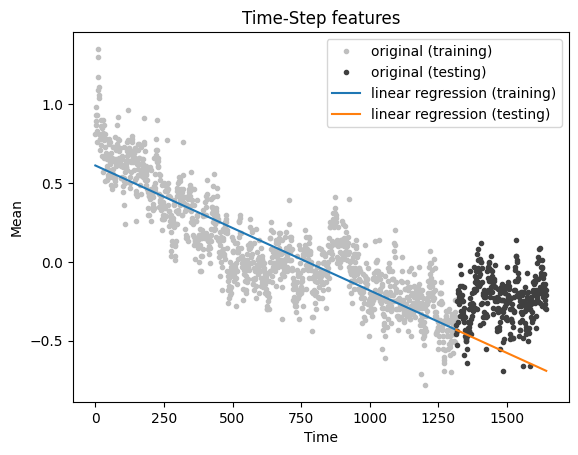

In [ ]:
# Add a 'Time' column as a numeric sequence
df_gistemp_copy['Time'] = np.arange(len(df_gistemp_copy))

# Sort the DataFrame by 'Time' in ascending order
df_gistemp_copy.sort_values(by='Time', ascending=True, inplace=True)

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gistemp_copy))

# Split GISTEMP dataset into training and testing using iloc
X_train = df_gistemp_copy.iloc[:threshold_index][['Time']]
y_train = df_gistemp_copy.iloc[:threshold_index]['Mean']
X_test = df_gistemp_copy.iloc[threshold_index:][['Time']]
y_test = df_gistemp_copy.iloc[threshold_index:]['Mean']

# Initialize and fit the Linear Regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate predictions for plotting
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Create the plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(X_train, y_train, '.', color='0.75', label='original (training)')  # Plot the training data
ax.plot(X_test, y_test, '.', color='0.25', label='original (testing)')    # Plot the testing data
ax.plot(X_train, y_train_pred, label='linear regression (training)')      # Plot the training predictions
ax.plot(X_test, y_test_pred, label='linear regression (testing)')          # Plot the testing predictions
ax.set_xlabel('Time')
ax.set_ylabel('Mean')
ax.set_title('Time-Step features')
ax.legend()
plt.show()


In [ ]:
# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print()
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")


Training RMSE: 0.1728
Training MAE: 0.1364
Training MSE: 0.0299

Testing RMSE: 0.3644
Testing MAE: 0.3261
Testing MSE: 0.1328


 Adding Lag Feature and Training Linear Regression Model

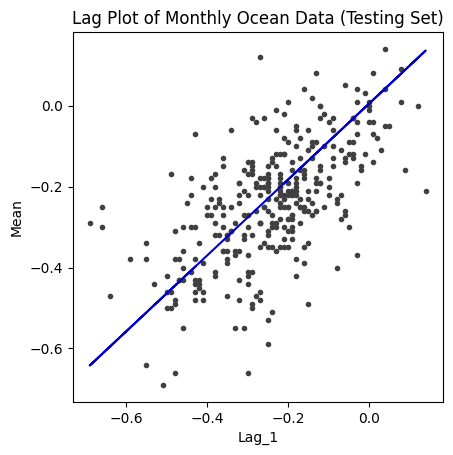

In [ ]:
# Add a 'Lag_1' column as a lag feature
df_gistemp_copy['Lag_1'] = df_gistemp_copy['Mean'].shift(1)

# Remove rows with NaN values in the 'Lag_1' column
df_gistemp_copy.dropna(subset=['Lag_1'], inplace=True)

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gistemp_copy))

# Split GISTEMP dataset into training and testing using iloc
X_train = df_gistemp_copy.iloc[:threshold_index][['Lag_1']]
y_train = df_gistemp_copy.iloc[:threshold_index]['Mean']
X_test = df_gistemp_copy.iloc[threshold_index:][['Lag_1']]
y_test = df_gistemp_copy.iloc[threshold_index:]['Mean']

# Initialize and fit the Linear Regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create the lag plot for the testing set
fig, ax = plt.subplots()
ax.plot(X_test['Lag_1'], y_test, '.', color='0.25')  # Plot the data points
ax.plot(X_test['Lag_1'], y_test_pred, color='mediumblue')  # Plot the predicted values
ax.set_aspect('equal')
ax.set_xlabel('Lag_1')
ax.set_ylabel('Mean')
ax.set_title('Lag Plot of Monthly Ocean Data (Testing Set)')
plt.show()


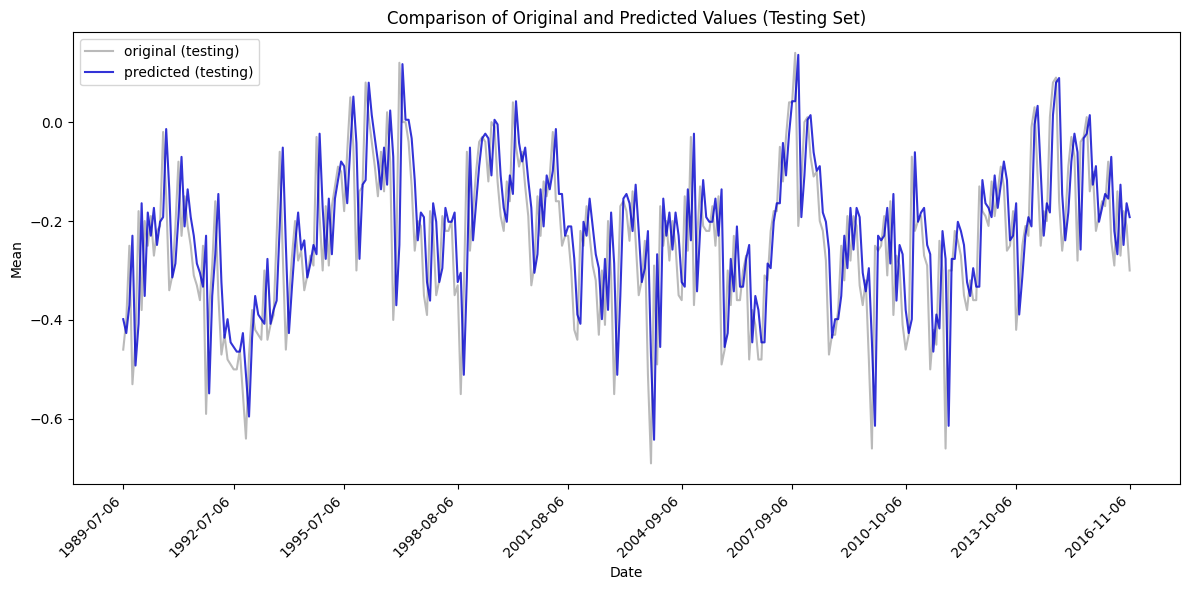

In [ ]:
# Sort the DataFrame by Date in ascending order
df_gistemp_copy.sort_values(by='Date', ascending=True, inplace=True)

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
fig.autofmt_xdate()

# Plot the original data for the testing set
ax.plot(df_gistemp_copy['Date'].iloc[len(X_train):], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df_gistemp_copy['Date'].iloc[len(X_train):], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(len(X_train), len(df_gistemp_copy) - 1, num_ticks, dtype=int)
x_ticks = df_gistemp_copy['Date'].iloc[x_tick_indices]

plt.xticks(x_ticks[::-1], rotation=45)  # Reverse and rotate x-axis labels for better visibility

plt.xlabel('Date')
plt.ylabel('Mean')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()


In [ ]:
# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print()
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Training RMSE: 0.1198
Training MAE: 0.0932
Training MSE: 0.0143

Testing RMSE: 0.1263
Testing MAE: 0.0977
Testing MSE: 0.0160


Polynomial Regression

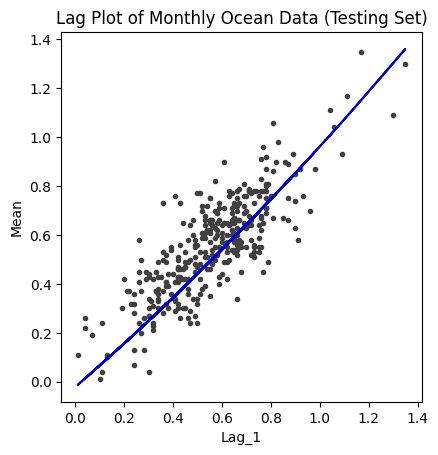

In [ ]:
# Add a 'Lag_1' column as a lag feature
df_gistemp_copy['Lag_1'] = df_gistemp_copy['Mean'].shift(1)

# Remove rows with NaN values in the 'Lag_1' column
df_gistemp_copy.dropna(subset=['Lag_1'], inplace=True)

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gistemp_copy))

# Split GISTEMP dataset into training and testing using iloc
X_train = df_gistemp_copy.iloc[:threshold_index][['Lag_1']]
y_train = df_gistemp_copy.iloc[:threshold_index]['Mean']
X_test = df_gistemp_copy.iloc[threshold_index:][['Lag_1']]
y_test = df_gistemp_copy.iloc[threshold_index:]['Mean']

# Extract the target variable (y) and input feature (X) for polynomial regression
X_poly = df_gistemp_copy[['Lag_1']]
y_poly = df_gistemp_copy['Mean']

# Apply polynomial regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_poly)

# Split the polynomial features into training and testing sets
X_train_poly = X_poly[:threshold_index]
X_test_poly = X_poly[threshold_index:]

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predictions for plotting
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Create the lag plot for the testing set
fig, ax = plt.subplots()
ax.plot(X_test['Lag_1'], y_test, '.', color='0.25')  # Plot the data points
ax.plot(X_test['Lag_1'], y_test_pred, color='mediumblue')  # Plot the predicted values
ax.set_aspect('equal')
ax.set_xlabel('Lag_1')
ax.set_ylabel('Mean')
ax.set_title('Lag Plot of Monthly Ocean Data (Testing Set)')
plt.show()


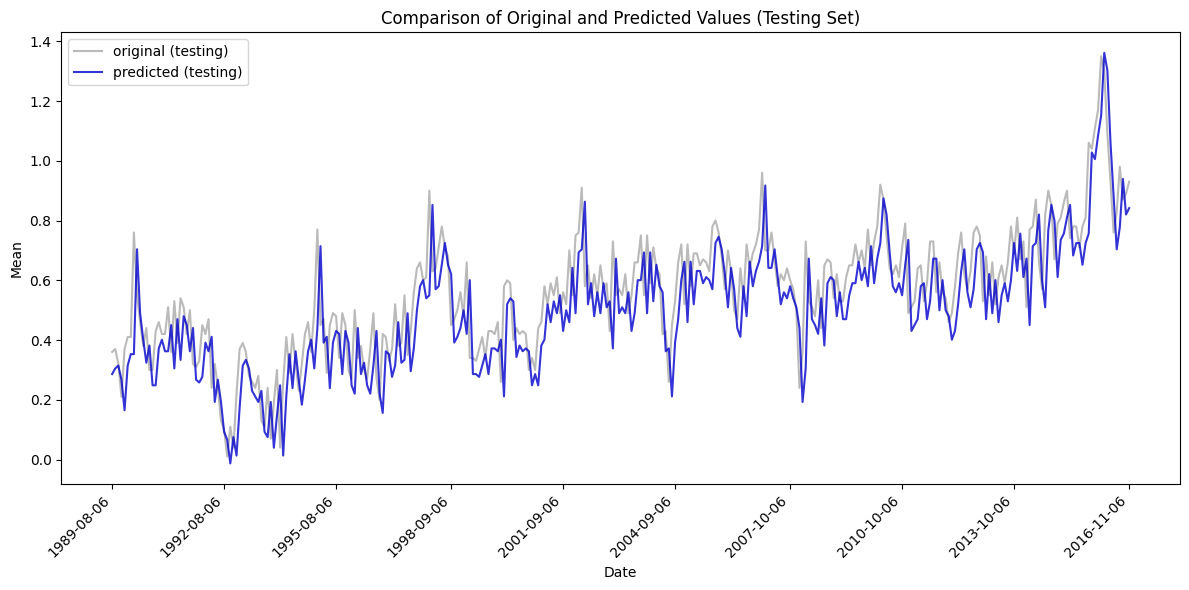

In [ ]:
# Create a plot for comparison (Polynomial Regression)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
fig.autofmt_xdate()

# Sort the DataFrame by Date in ascending order
df_gistemp_copy.sort_values(by='Date', ascending=True, inplace=True)

# Plot the original data for the testing set
ax.plot(df_gistemp_copy['Date'].iloc[len(X_train):], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df_gistemp_copy['Date'].iloc[len(X_train):], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(len(X_train), len(df_gistemp_copy) - 1, num_ticks, dtype=int)
x_ticks = df_gistemp_copy['Date'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

plt.xlabel('Date')
plt.ylabel('Mean')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()


In [ ]:
# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")

print("\nTesting Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")

Training Metrics:
RMSE: 0.1181
MAE: 0.0914
MSE: 0.0140

Testing Metrics:
RMSE: 0.1356
MAE: 0.1107
MSE: 0.0184


ANN Model

Epoch 1/20
41/41 [==============================] - 1s 7ms/step - loss: 0.0521 - val_loss: 0.4525
Epoch 2/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0327 - val_loss: 0.2042
Epoch 3/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.1476
Epoch 4/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0247 - val_loss: 0.1087
Epoch 5/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.1154
Epoch 6/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.1004
Epoch 7/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0237 - val_loss: 0.1167
Epoch 8/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0238 - val_loss: 0.1036
Epoch 9/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0906
Epoch 10/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0237 - val_loss: 0.1018
Epoch 11/20
41/41 [

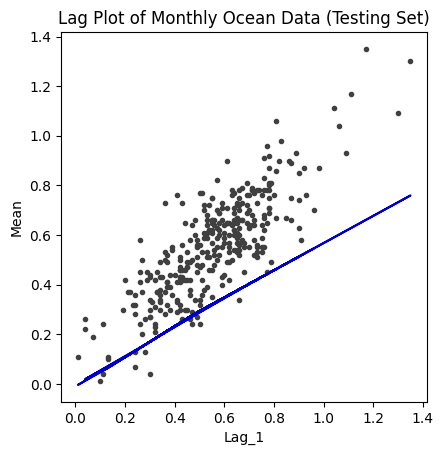

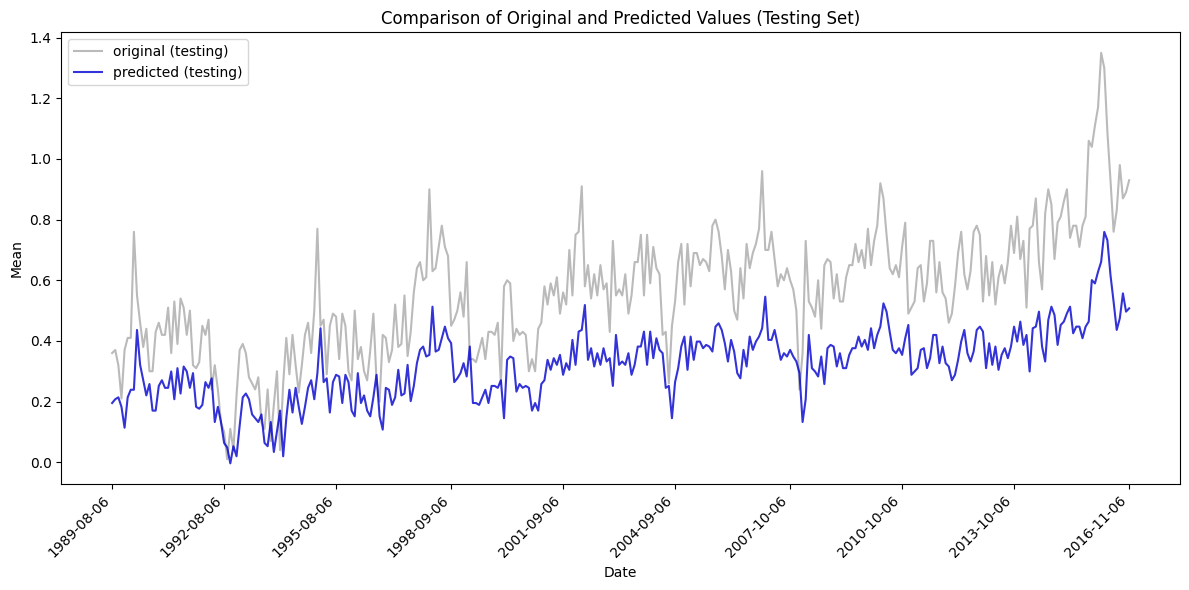

Training RMSE: 0.1256
Training MAE: 0.0978
Training MSE: 0.0158

Testing RMSE: 0.2689
Testing MAE: 0.2391
Testing MSE: 0.0723


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gistemp_copy))

# Split GISTEMP dataset into training and testing using iloc
X_train = df_gistemp_copy.iloc[:threshold_index][['Lag_1']]
y_train = df_gistemp_copy.iloc[:threshold_index]['Mean']
X_test = df_gistemp_copy.iloc[threshold_index:][['Lag_1']]
y_test = df_gistemp_copy.iloc[threshold_index:]['Mean']

# Define and compile the ANN model with dropout layers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(1,)))
model.add(Dropout(0.2))  # Add a dropout layer with a 20% dropout rate
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create the lag plot for the testing set
fig, ax = plt.subplots()
ax.plot(X_test, y_test, '.', color='0.25')  # Plot the data points
ax.plot(X_test, y_test_pred, color='mediumblue')  # Plot the predicted values
ax.set_aspect('equal')
ax.set_xlabel('Lag_1')
ax.set_ylabel('Mean')
ax.set_title('Lag Plot of Monthly Ocean Data (Testing Set)')
plt.show()

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
fig.autofmt_xdate()

# Plot the original data for the testing set
ax.plot(df_gistemp_copy['Date'].iloc[threshold_index:], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df_gistemp_copy['Date'].iloc[threshold_index:], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df_gistemp_copy) - 1, num_ticks, dtype=int)
x_ticks = df_gistemp_copy['Date'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

plt.xlabel('Date')
plt.ylabel('Mean')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print()
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")


Linear Regression - >

Training RMSE: 0.1198
Training MAE: 0.0932
Training MSE: 0.0143

Testing RMSE: 0.1263
Testing MAE: 0.0977
Testing MSE: 0.0160


Polynomial Regression - >

Training Metrics:
RMSE: 0.1181
MAE: 0.0914
MSE: 0.0140

Testing Metrics:
RMSE: 0.1356
MAE: 0.1107
MSE: 0.0184


ANN - >

Training RMSE: 0.1256
Training MAE: 0.0978
Training MSE: 0.0158

Testing RMSE: 0.2689
Testing MAE: 0.2391
Testing MSE: 0.0723

In the comparison of regression models, Polynomial Regression exhibits the lowest RMSE and MAE on both training and testing datasets, indicating its superior performance in capturing the underlying data patterns. In contrast, Linear Regression performs slightly better than the Artificial Neural Network (ANN), as it achieves lower RMSE and MAE values on the testing set, suggesting a more reliable and interpretable model for this specific dataset.






### For df_gcag(Q1)

Creating a Time-Step Feature and Linear Regression

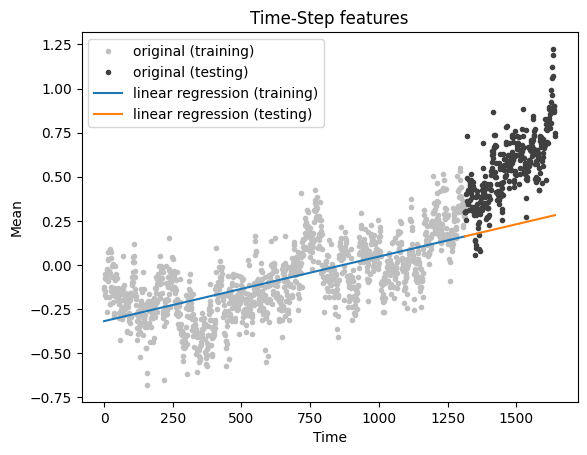

In [ ]:
# Add a 'Time' column as a numeric sequence
df_gcag_copy['Time'] = np.arange(len(df_gcag_copy))

# Sort the DataFrame by 'Time' in ascending order
df_gcag_copy.sort_values(by='Time', ascending=True, inplace=True)

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gcag_copy))

# Split GCAG dataset into training and testing using iloc
X_train = df_gcag_copy.iloc[:threshold_index][['Time']]
y_train = df_gcag_copy.iloc[:threshold_index]['Mean']
X_test = df_gcag_copy.iloc[threshold_index:][['Time']]
y_test = df_gcag_copy.iloc[threshold_index:]['Mean']

# Initialize and fit the Linear Regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate predictions for plotting
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Create the plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(X_train, y_train, '.', color='0.75', label='original (training)')  # Plot the training data
ax.plot(X_test, y_test, '.', color='0.25', label='original (testing)')    # Plot the testing data
ax.plot(X_train, y_train_pred, label='linear regression (training)')      # Plot the training predictions
ax.plot(X_test, y_test_pred, label='linear regression (testing)')          # Plot the testing predictions
ax.set_xlabel('Time')
ax.set_ylabel('Mean')
ax.set_title('Time-Step features')
ax.legend()
plt.show()


In [ ]:
# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print()
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")


Training RMSE: 0.1570
Training MAE: 0.1260
Training MSE: 0.0247

Testing RMSE: 0.3698
Testing MAE: 0.3340
Testing MSE: 0.1367


Adding Lag feature and training Regression Model

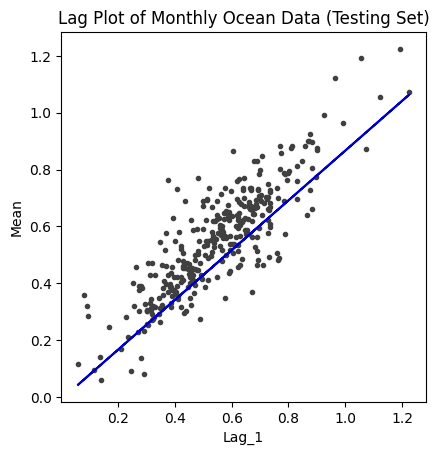

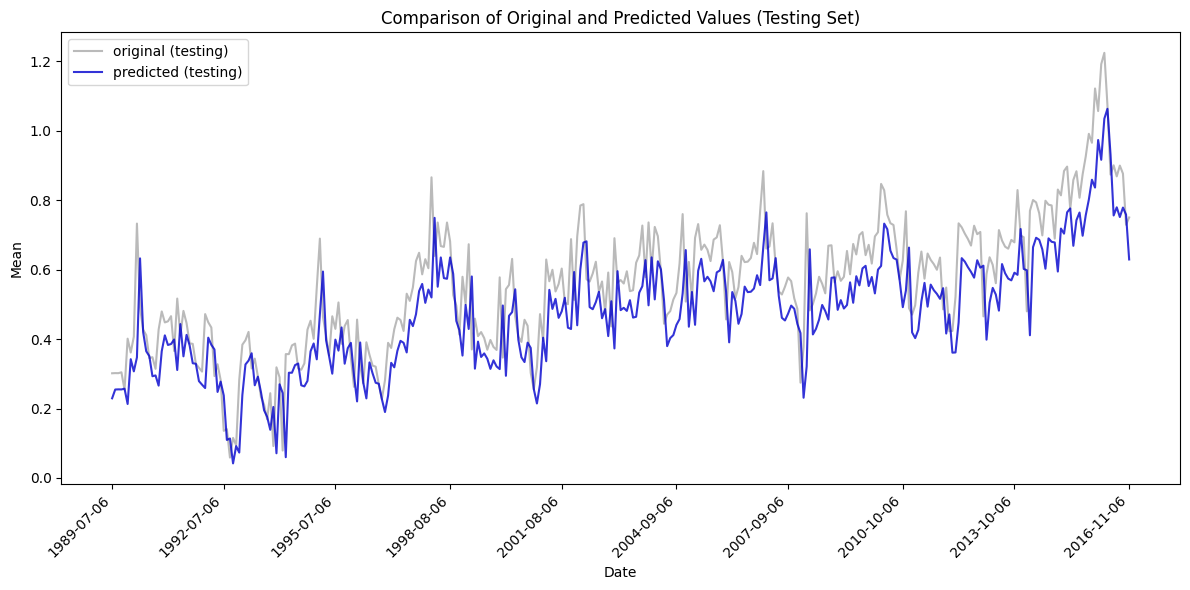

Training RMSE: 0.1014
Training MAE: 0.0750
Training MSE: 0.0103

Testing RMSE: 0.1268
Testing MAE: 0.1016
Testing MSE: 0.0161


In [ ]:
# Add a 'Lag_1' column as a lag feature
df_gcag_copy['Lag_1'] = df_gcag_copy['Mean'].shift(1)

# Remove rows with NaN values in the 'Lag_1' column
df_gcag_copy.dropna(subset=['Lag_1'], inplace=True)

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gcag_copy))

# Split GCAG dataset into training and testing using iloc
X_train = df_gcag_copy.iloc[:threshold_index][['Lag_1']]
y_train = df_gcag_copy.iloc[:threshold_index]['Mean']
X_test = df_gcag_copy.iloc[threshold_index:][['Lag_1']]
y_test = df_gcag_copy.iloc[threshold_index:]['Mean']

# Initialize and fit the Linear Regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create the lag plot for the testing set
fig, ax = plt.subplots()
ax.plot(X_test['Lag_1'], y_test, '.', color='0.25')  # Plot the data points
ax.plot(X_test['Lag_1'], y_test_pred, color='mediumblue')  # Plot the predicted values
ax.set_aspect('equal')
ax.set_xlabel('Lag_1')
ax.set_ylabel('Mean')
ax.set_title('Lag Plot of Monthly Ocean Data (Testing Set)')
plt.show()

# Sort the DataFrame by Date in ascending order
df_gcag_copy.sort_values(by='Date', ascending=True, inplace=True)

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
fig.autofmt_xdate()

# Plot the original data for the testing set
ax.plot(df_gcag_copy['Date'].iloc[len(X_train):], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df_gcag_copy['Date'].iloc[len(X_train):], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(len(X_train), len(df_gcag_copy) - 1, num_ticks, dtype=int)
x_ticks = df_gcag_copy['Date'].iloc[x_tick_indices]

plt.xticks(x_ticks[::-1], rotation=45)  # Reverse and rotate x-axis labels for better visibility

plt.xlabel('Date')
plt.ylabel('Mean')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()


# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print()
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Polynomial Regression

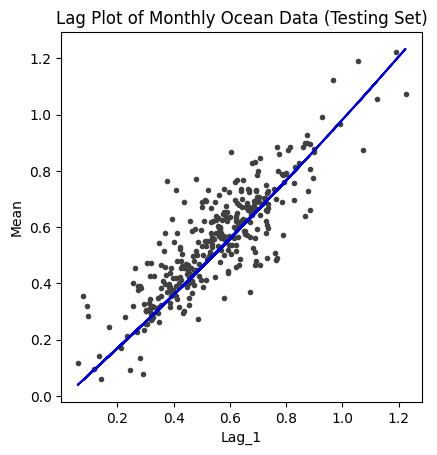

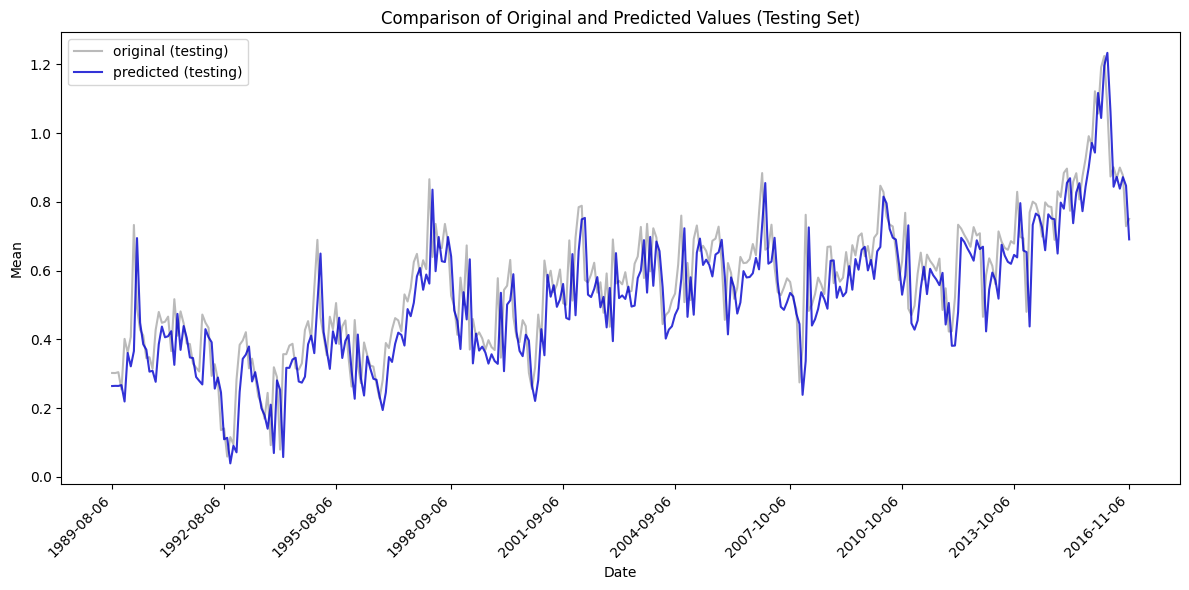

Training Metrics:
RMSE: 0.1012
MAE: 0.0751
MSE: 0.0103

Testing Metrics:
RMSE: 0.1111
MAE: 0.0840
MSE: 0.0123


In [ ]:
# Add a 'Lag_1' column as a lag feature
df_gcag_copy['Lag_1'] = df_gcag_copy['Mean'].shift(1)

# Remove rows with NaN values in the 'Lag_1' column
df_gcag_copy.dropna(subset=['Lag_1'], inplace=True)

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gcag_copy))

# Split GCAG dataset into training and testing using iloc
X_train = df_gcag_copy.iloc[:threshold_index][['Lag_1']]
y_train = df_gcag_copy.iloc[:threshold_index]['Mean']
X_test = df_gcag_copy.iloc[threshold_index:][['Lag_1']]
y_test = df_gcag_copy.iloc[threshold_index:]['Mean']

# Extract the target variable (y) and input feature (X) for polynomial regression
X_poly = df_gcag_copy[['Lag_1']]
y_poly = df_gcag_copy['Mean']

# Apply polynomial regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_poly)

# Split the polynomial features into training and testing sets
X_train_poly = X_poly[:threshold_index]
X_test_poly = X_poly[threshold_index:]

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predictions for plotting
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Create the lag plot for the testing set
fig, ax = plt.subplots()
ax.plot(X_test['Lag_1'], y_test, '.', color='0.25')  # Plot the data points
ax.plot(X_test['Lag_1'], y_test_pred, color='mediumblue')  # Plot the predicted values
ax.set_aspect('equal')
ax.set_xlabel('Lag_1')
ax.set_ylabel('Mean')
ax.set_title('Lag Plot of Monthly Ocean Data (Testing Set)')
plt.show()

# Create a plot for comparison (Polynomial Regression)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
fig.autofmt_xdate()

# Sort the DataFrame by Date in ascending order
df_gcag_copy.sort_values(by='Date', ascending=True, inplace=True)

# Plot the original data for the testing set
ax.plot(df_gcag_copy['Date'].iloc[len(X_train):], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df_gcag_copy['Date'].iloc[len(X_train):], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(len(X_train), len(df_gcag_copy) - 1, num_ticks, dtype=int)
x_ticks = df_gcag_copy['Date'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

plt.xlabel('Date')
plt.ylabel('Mean')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")

print("\nTesting Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")


ANN Model

Epoch 1/20
41/41 [==============================] - 1s 6ms/step - loss: 0.0250 - val_loss: 0.1396
Epoch 2/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0573
Epoch 3/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0515
Epoch 4/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0392
Epoch 5/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0333
Epoch 6/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0321
Epoch 7/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0359
Epoch 8/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0362
Epoch 9/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0340
Epoch 10/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0334
Epoch 11/20
41/41 [

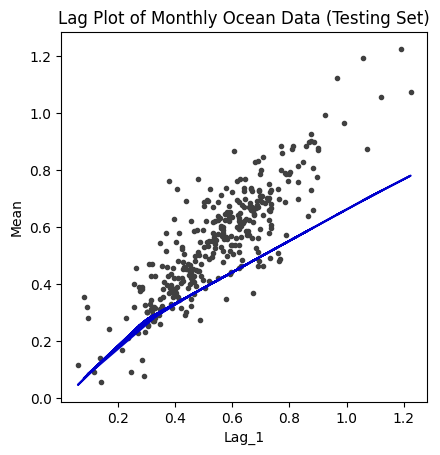

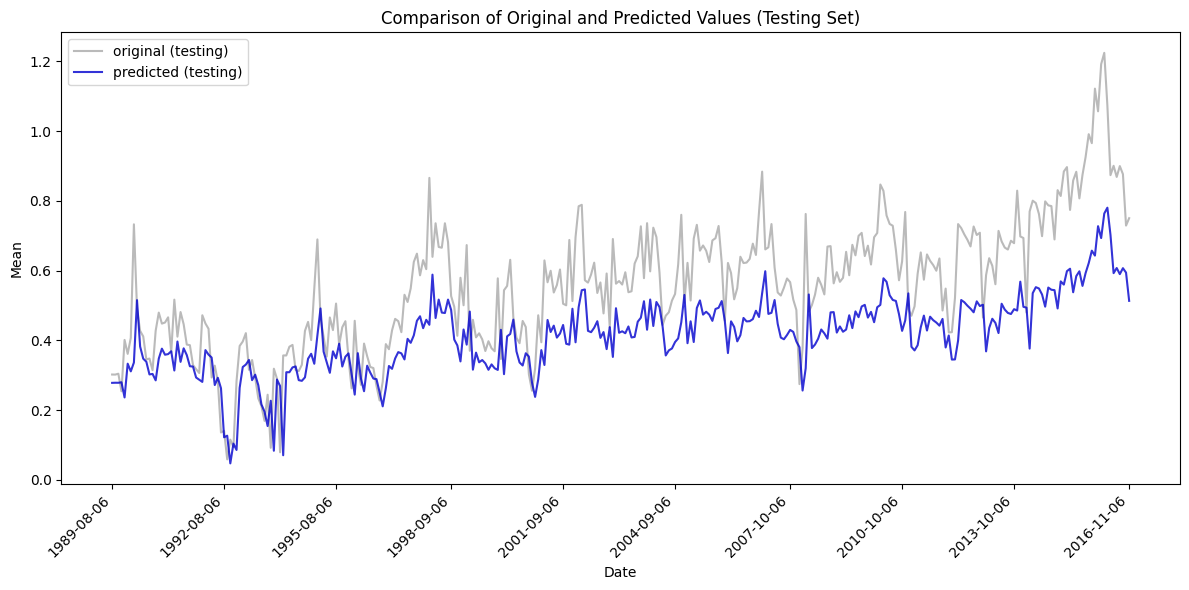

Training RMSE: 0.1007
Training MAE: 0.0748
Training MSE: 0.0101

Testing RMSE: 0.1798
Testing MAE: 0.1492
Testing MSE: 0.0323


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df_gcag_copy))

# Split GCAP dataset into training and testing using iloc
X_train = df_gcag_copy.iloc[:threshold_index][['Lag_1']]
y_train = df_gcag_copy.iloc[:threshold_index]['Mean']
X_test = df_gcag_copy.iloc[threshold_index:][['Lag_1']]
y_test = df_gcag_copy.iloc[threshold_index:]['Mean']

# Define and compile the ANN model with dropout layers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(1,)))
#model.add(Dropout(0.2))  # Add a dropout layer with a 20% dropout rate
model.add(Dense(8, activation='relu'))
#model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(4, activation='relu'))
#model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create the lag plot for the testing set
fig, ax = plt.subplots()
ax.plot(X_test, y_test, '.', color='0.25')  # Plot the data points
ax.plot(X_test, y_test_pred, color='mediumblue')  # Plot the predicted values
ax.set_aspect('equal')
ax.set_xlabel('Lag_1')
ax.set_ylabel('Mean')
ax.set_title('Lag Plot of Monthly Ocean Data (Testing Set)')
plt.show()

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
fig.autofmt_xdate()

# Plot the original data for the testing set
ax.plot(df_gcag_copy['Date'].iloc[threshold_index:], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df_gcag_copy['Date'].iloc[threshold_index:], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df_gcag_copy) - 1, num_ticks, dtype=int)
x_ticks = df_gcag_copy['Date'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

plt.xlabel('Date')
plt.ylabel('Mean')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print()
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")


### Results and conclusion(Q1)

Linear regression - >

Training RMSE: 0.1014
Training MAE: 0.0750
Training MSE: 0.0103

Testing RMSE: 0.1268
Testing MAE: 0.1016
Testing MSE: 0.0161

Polynomial Regression - >

Training Metrics:
RMSE: 0.1012
MAE: 0.0751
MSE: 0.0103

Testing Metrics:
RMSE: 0.1111
MAE: 0.0840
MSE: 0.0123

ANN Model - >

Training RMSE: 0.1007
Training MAE: 0.0748
Training MSE: 0.0101

Testing RMSE: 0.1798
Testing MAE: 0.1492
Testing MSE: 0.0323

Among the three models, Linear Regression and Polynomial Regression exhibit the best overall performance, achieving low training and testing RMSE and MAE values, indicating their ability to accurately predict the target variable. In contrast, the ANN model, while performing well on the training data, shows signs of overfitting on the testing set, as evidenced by the significantly higher testing RMSE and MAE values.






### **Electricty Forecast Dataset (Q2)**

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Electricity_load_forecasting.csv')
df2.head(5)

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
print(df2.isnull().sum())

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64


In [ ]:
# Add a lag(1) feature to 'nat_demand'
df2['Lag_1'] = df2['nat_demand'].shift(1)

# Add a moving average (MA) feature with a window size of 3 to 'nat_demand'
df2['MA_3'] = df2['nat_demand'].rolling(window=3).mean()

# Drop rows with null values (NaN) in the new columns
df2.dropna(subset=['Lag_1', 'MA_3'], inplace=True)

In [ ]:
df2_copy=df2.copy()

In [ ]:
df2_copy.head(5)

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,Lag_1,MA_3
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0,912.1755,927.596433
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0,900.2688,900.799367
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0,889.9538,894.636367
5,03-01-2015 06:00,879.2323,26.034143,0.019080,0.014542,20.062038,22.995081,0.017028,0.001485,9.087273,22.456018,0.016410,0.061539,5.280351,0,0,0,893.6865,887.624200
6,03-01-2015 07:00,932.4876,26.691492,0.019332,0.006645,21.623496,24.285242,0.017424,0.002176,11.395393,22.949304,0.016570,0.060898,5.126911,0,0,0,879.2323,901.802133


### Linear Regression

In [ ]:
# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df2_copy))

# Split the dataset into training and testing using iloc
X_train = df2_copy.iloc[:threshold_index].drop(['datetime', 'nat_demand'], axis=1)
y_train = df2_copy.iloc[:threshold_index]['nat_demand']
X_test = df2_copy.iloc[threshold_index:].drop(['datetime', 'nat_demand'], axis=1)
y_test = df2_copy.iloc[threshold_index:]['nat_demand']

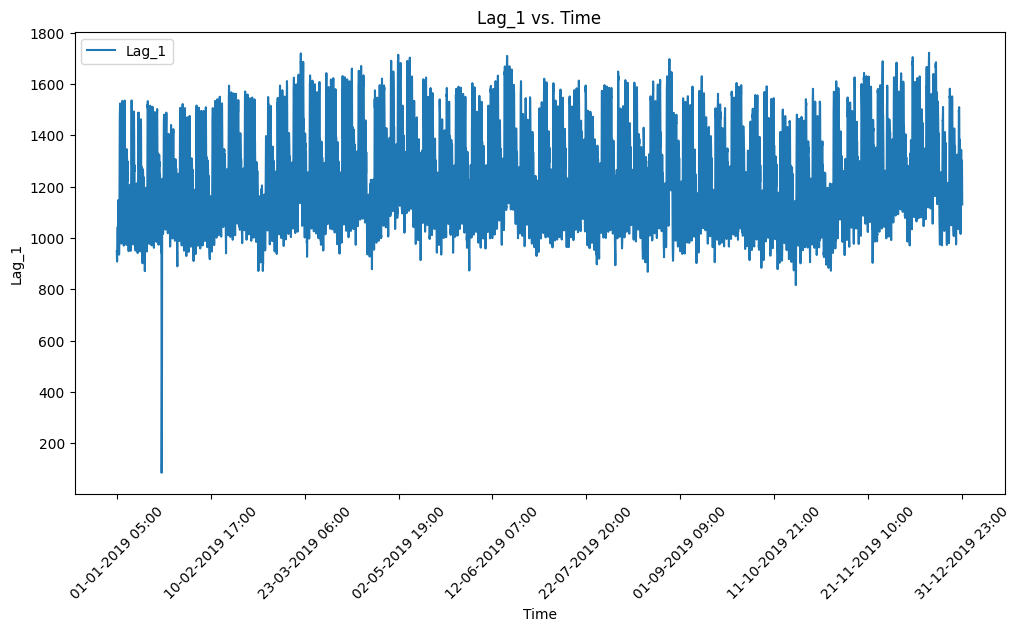

In [ ]:
# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Predictions on the test set
y_test_pred = model.predict(X_test)
# Plotting a variable (e.g., lag) against time
variable_name = 'Lag_1'
plt.figure(figsize=(12, 6))
plt.plot(df2_copy['datetime'].iloc[threshold_index:], X_test[variable_name], label=variable_name)
plt.xlabel('Time')
plt.ylabel(variable_name)
plt.title(f'{variable_name} vs. Time')

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]
plt.xticks(x_ticks, rotation=45)

plt.legend()
plt.show()

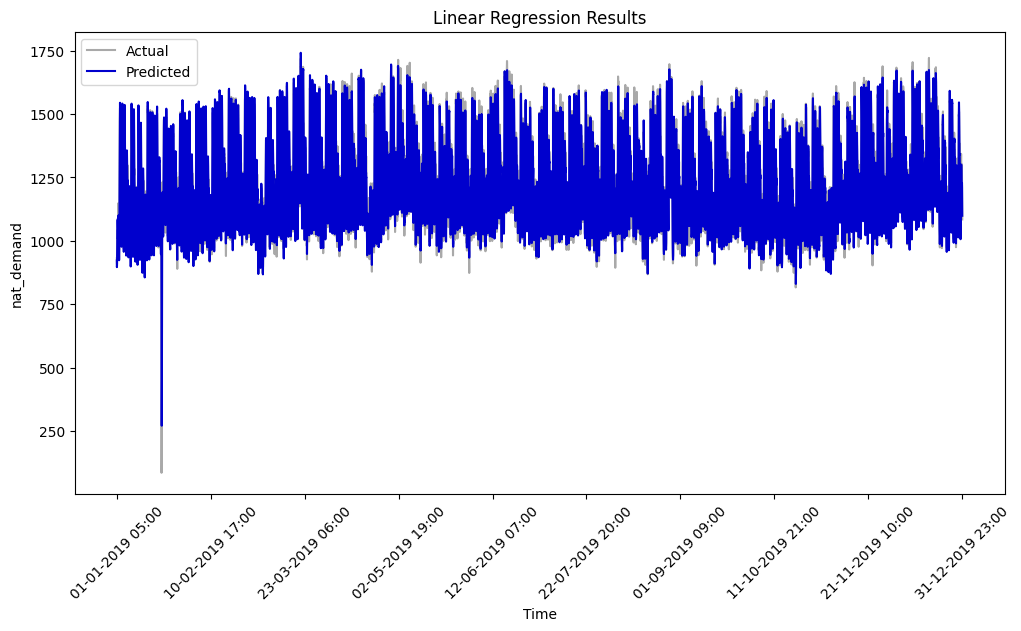

Training Metrics:
RMSE: 50.0548
MAE: 38.6008
MSE: 2505.4867

Testing Metrics:
RMSE: 49.3725
MAE: 37.6676
MSE: 2437.6449


In [ ]:
# Plot the results of Linear Regression
plt.figure(figsize=(12, 6))
plt.plot(df2_copy['datetime'].iloc[threshold_index:], y_test, label='Actual', color='darkgray')
plt.plot(df2_copy['datetime'].iloc[threshold_index:], y_test_pred, label='Predicted', color='mediumblue')
plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Linear Regression Results')

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]
plt.xticks(x_ticks, rotation=45)

plt.legend()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print()
print("Testing Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")

### Polynomial Regression

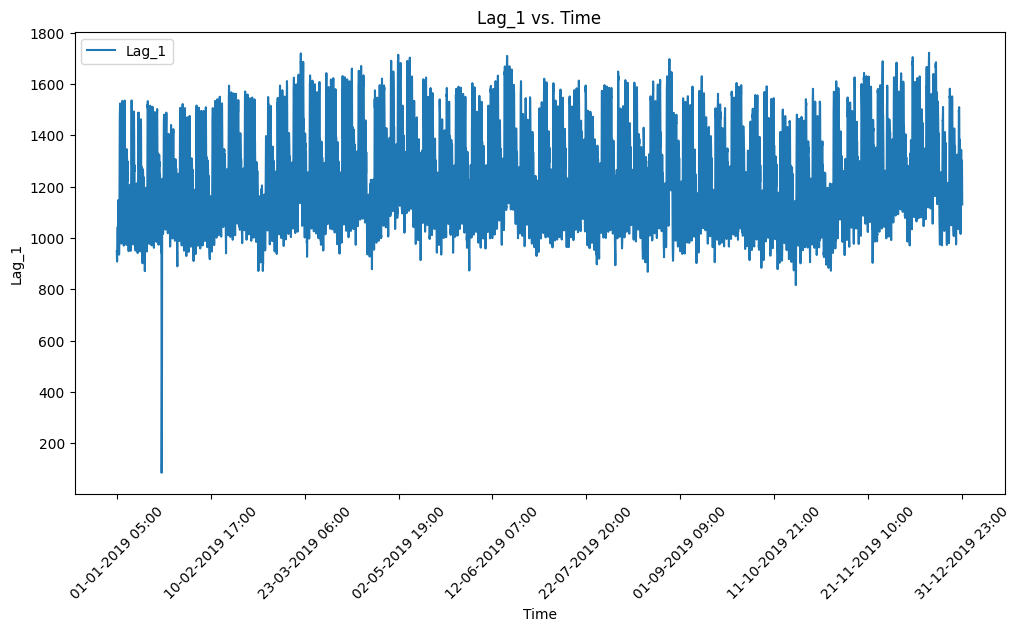

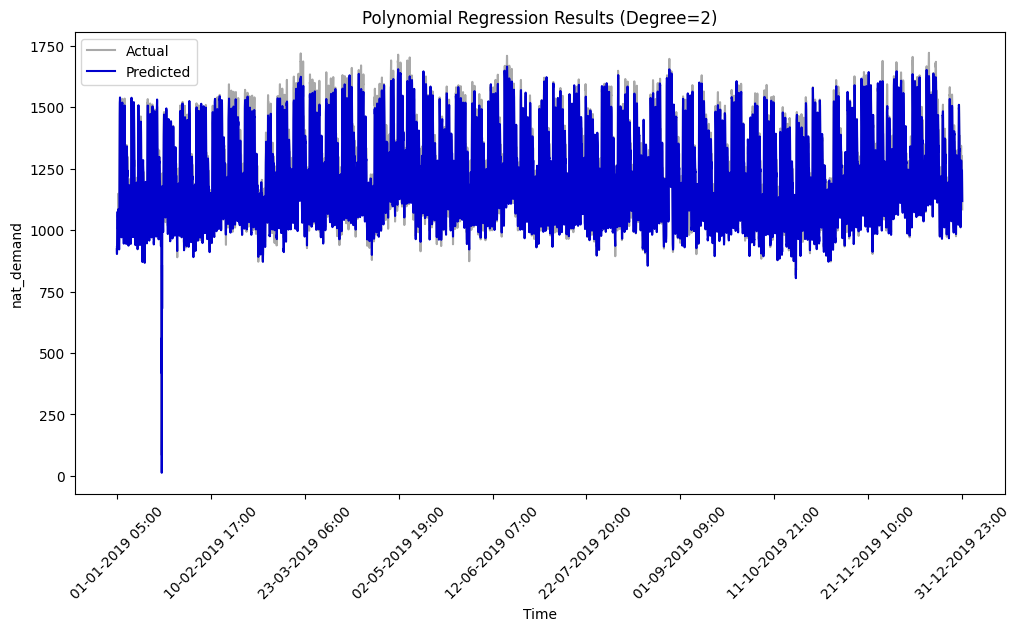

Training Metrics (Polynomial Regression):
RMSE: 44.4972
MAE: 34.4208
MSE: 1980.0046

Testing Metrics (Polynomial Regression):
RMSE: 46.5013
MAE: 35.4454
MSE: 2162.3681


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Initialize and fit the Polynomial Regression model
degree = 2  # You can adjust the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predictions on the test set
y_test_pred_poly = model.predict(X_test_poly)

# Plotting a variable (e.g., lag) against time
variable_name = 'Lag_1'
plt.figure(figsize=(12, 6))
plt.plot(df2_copy['datetime'].iloc[threshold_index:], X_test[variable_name], label=variable_name)
plt.xlabel('Time')
plt.ylabel(variable_name)
plt.title(f'{variable_name} vs. Time')

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]
plt.xticks(x_ticks, rotation=45)

plt.legend()
plt.show()

# Plot the results of Polynomial Regression
plt.figure(figsize=(12, 6))
plt.plot(df2_copy['datetime'].iloc[threshold_index:], y_test, label='Actual', color='darkgray')
plt.plot(df2_copy['datetime'].iloc[threshold_index:], y_test_pred_poly, label='Predicted', color='mediumblue')
plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Polynomial Regression Results (Degree={})'.format(degree))

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]
plt.xticks(x_ticks, rotation=45)

plt.legend()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
y_train_pred_poly = model.predict(X_train_poly)
train_rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
train_mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)

print("Training Metrics (Polynomial Regression):")
print(f"RMSE: {train_rmse_poly:.4f}")
print(f"MAE: {train_mae_poly:.4f}")
print(f"MSE: {train_mse_poly:.4f}")
print()
print("Testing Metrics (Polynomial Regression):")
print(f"RMSE: {test_rmse_poly:.4f}")
print(f"MAE: {test_mae_poly:.4f}")
print(f"MSE: {test_mse_poly:.4f}")

### Polynomial Regression with 3 features

<ipython-input-247-fe69e381e205>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df2_copy.corr()


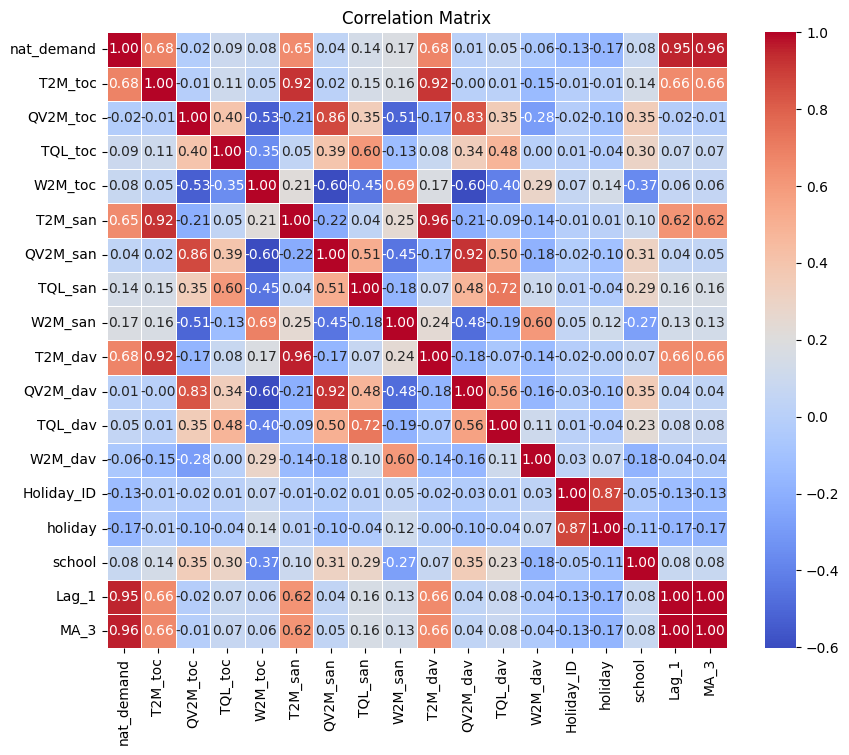

Top 4 most correlated features with 'nat_demand':
Index(['nat_demand', 'MA_3', 'Lag_1', 'T2M_toc'], dtype='object')


In [ ]:
# Calculate the correlation matrix
correlation_matrix = df2_copy.corr()

# Get the absolute correlations with the 'nat_demand' column and sort them in descending order
correlation_with_target = correlation_matrix['nat_demand'].abs().sort_values(ascending=False)

# Select the top 4 (including 'nat_demand' itself) most correlated features
top_features = correlation_with_target.index[:4]

# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Display the top correlated features
print("Top 4 most correlated features with 'nat_demand':")
print(top_features)

In [ ]:
# Select the features for training
selected_features = ['MA_3', 'Lag_1', 'T2M_toc']

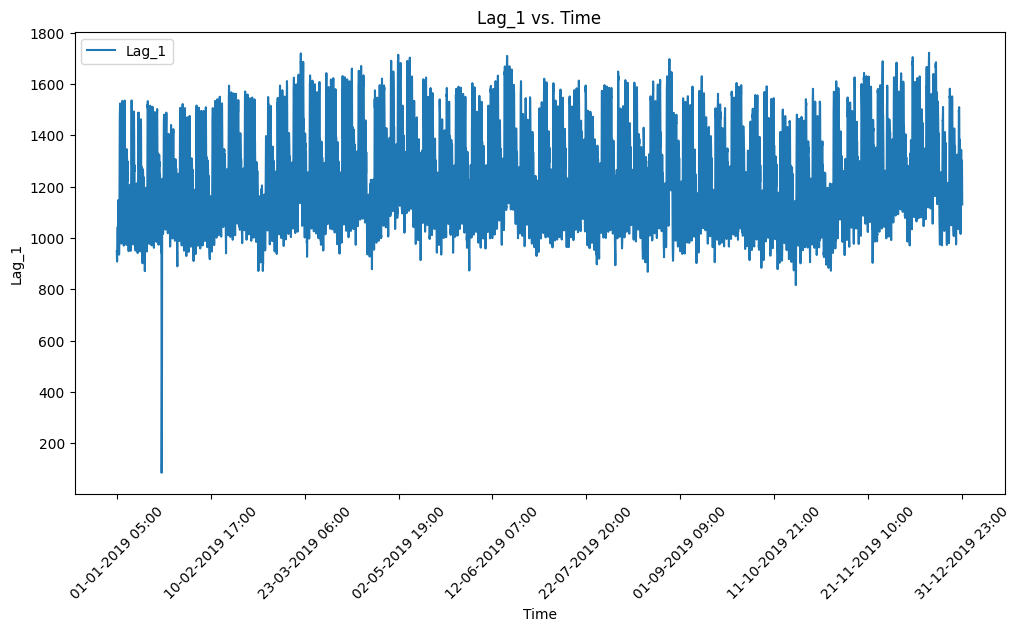

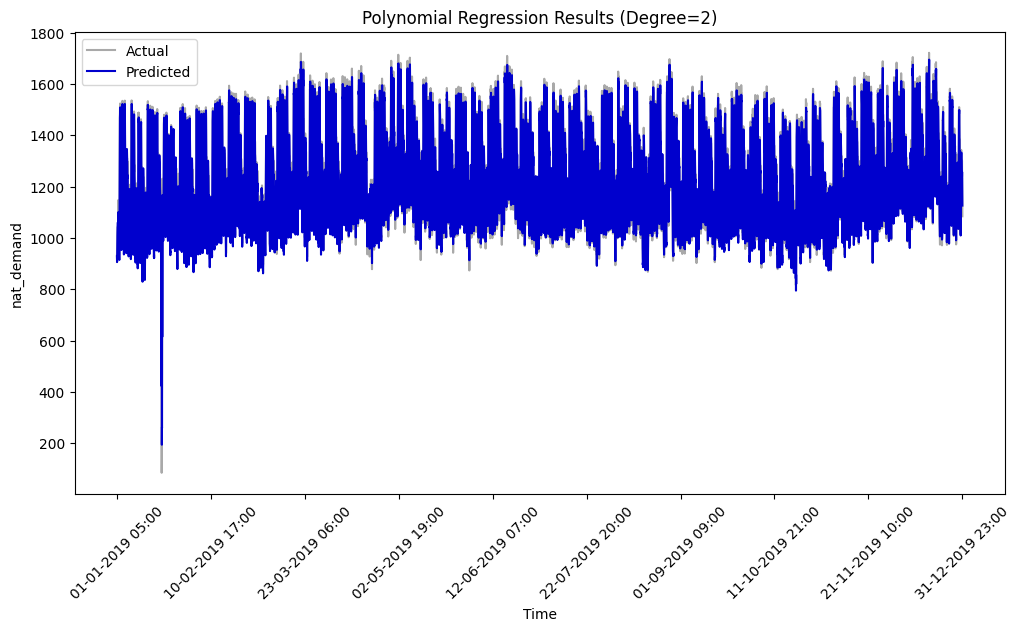

Training Metrics (Polynomial Regression):
RMSE: 52.2322
MAE: 40.2678
MSE: 2728.2050

Testing Metrics (Polynomial Regression):
RMSE: 53.0913
MAE: 40.3859
MSE: 2818.6825


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Initialize and fit the Polynomial Regression model
degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train[selected_features])
X_test_poly = poly_features.transform(X_test[selected_features])

model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predictions on the test set
y_test_pred_poly = model.predict(X_test_poly)

# Plotting a variable (e.g., lag) against time
variable_name = 'Lag_1'
plt.figure(figsize=(12, 6))
plt.plot(df2_copy['datetime'].iloc[threshold_index:], X_test[variable_name], label=variable_name)
plt.xlabel('Time')
plt.ylabel(variable_name)
plt.title(f'{variable_name} vs. Time')

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]
plt.xticks(x_ticks, rotation=45)

plt.legend()
plt.show()

# Plot the results of Polynomial Regression
plt.figure(figsize=(12, 6))
plt.plot(df2_copy['datetime'].iloc[threshold_index:], y_test, label='Actual', color='darkgray')
plt.plot(df2_copy['datetime'].iloc[threshold_index:], y_test_pred_poly, label='Predicted', color='mediumblue')
plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Polynomial Regression Results (Degree={})'.format(degree))

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]
plt.xticks(x_ticks, rotation=45)

plt.legend()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
y_train_pred_poly = model.predict(X_train_poly)
train_rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
train_mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)

print("Training Metrics (Polynomial Regression):")
print(f"RMSE: {train_rmse_poly:.4f}")
print(f"MAE: {train_mae_poly:.4f}")
print(f"MSE: {train_mse_poly:.4f}")
print()
print("Testing Metrics (Polynomial Regression):")
print(f"RMSE: {test_rmse_poly:.4f}")
print(f"MAE: {test_mae_poly:.4f}")
print(f"MSE: {test_mse_poly:.4f}")

### ANN Model on all features with droupout

Epoch 1/20
1095/1095 [==============================] - 4s 3ms/step - loss: 301725.5938 - val_loss: 138728.6094
Epoch 2/20
1095/1095 [==============================] - 3s 3ms/step - loss: 196451.7031 - val_loss: 171602.5469
Epoch 3/20
1095/1095 [==============================] - 3s 3ms/step - loss: 160995.2031 - val_loss: 205456.9062
Epoch 4/20
1095/1095 [==============================] - 4s 3ms/step - loss: 148252.7031 - val_loss: 217473.7188
Epoch 5/20
1095/1095 [==============================] - 2s 2ms/step - loss: 145815.4375 - val_loss: 219290.5312
Epoch 6/20
1095/1095 [==============================] - 3s 2ms/step - loss: 143736.0625 - val_loss: 217209.2656
Epoch 7/20
1095/1095 [==============================] - 2s 2ms/step - loss: 140733.0156 - val_loss: 221286.5938
Epoch 8/20
1095/1095 [==============================] - 3s 3ms/step - loss: 139331.6406 - val_loss: 249350.3125
Epoch 9/20
1095/1095 [==============================] - 3s 3ms/step - loss: 138520.0312 - val_loss: 2150

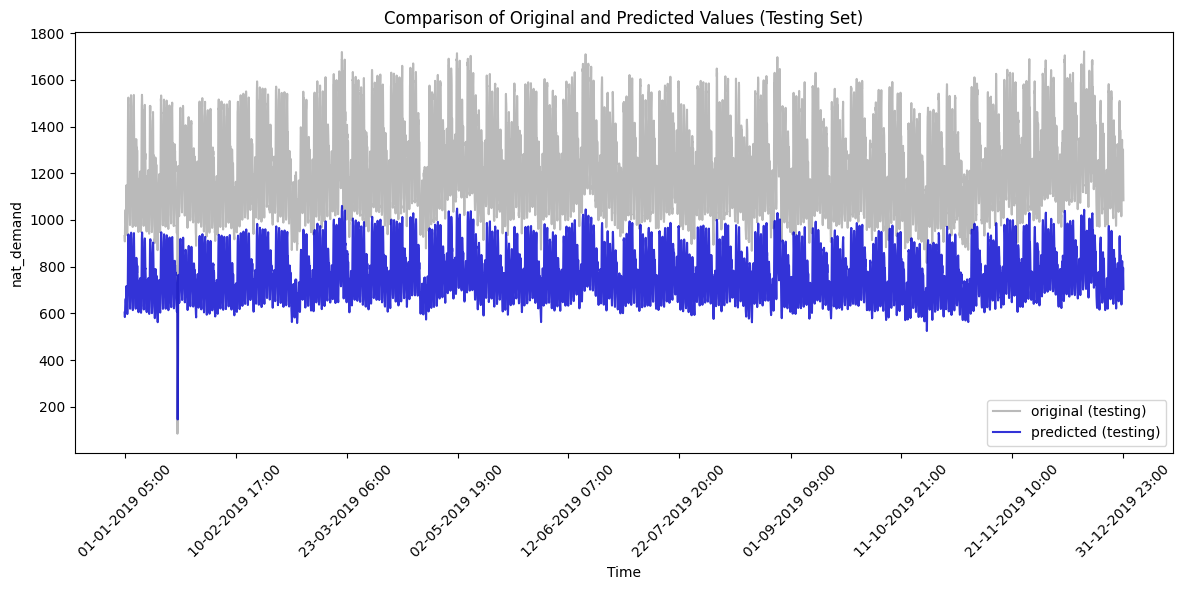

Training Metrics (ANN):
RMSE: 447.2276
MAE: 437.8387
MSE: 200012.5482

Testing Metrics (ANN):
RMSE: 477.1419
MAE: 468.6305
MSE: 227664.3898


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Define and compile the ANN model with dropout layers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(17,)))  # Adjust the input shape based on your dataframe
model.add(Dropout(0.2))  # Add a dropout layer with a 20% dropout rate
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data for the testing set
ax.plot(df2_copy['datetime'].iloc[threshold_index:], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df2_copy['datetime'].iloc[threshold_index:], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics (ANN):")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print()
print("Testing Metrics (ANN):")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")


### ANN Model on 3 features with dropout

<ipython-input-237-fe69e381e205>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df2_copy.corr()


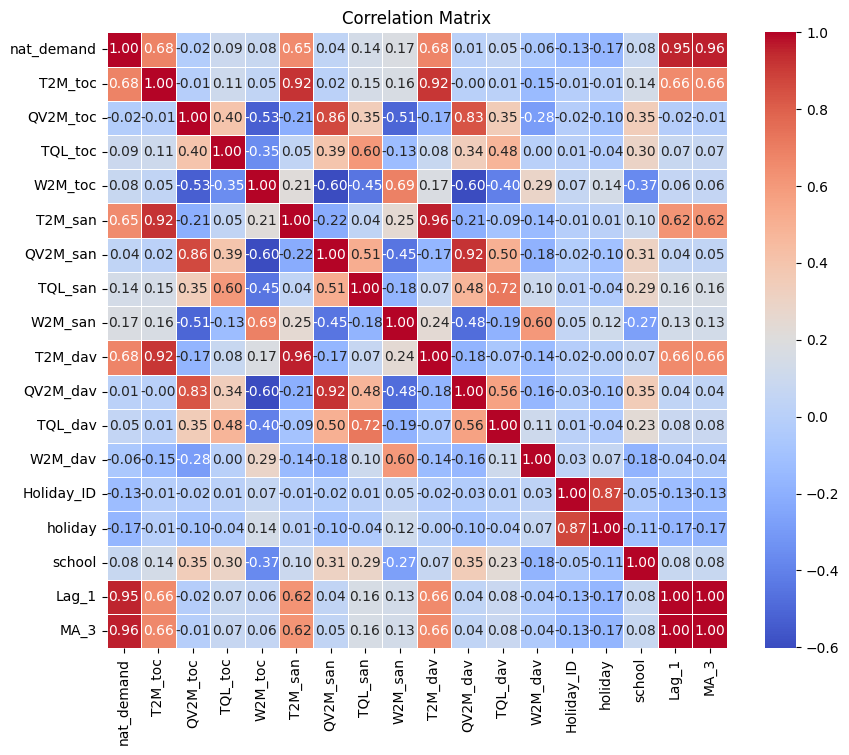

Top 4 most correlated features with 'nat_demand':
Index(['nat_demand', 'MA_3', 'Lag_1', 'T2M_toc'], dtype='object')


In [ ]:
# Calculate the correlation matrix
correlation_matrix = df2_copy.corr()

# Get the absolute correlations with the 'nat_demand' column and sort them in descending order
correlation_with_target = correlation_matrix['nat_demand'].abs().sort_values(ascending=False)

# Select the top 4 (including 'nat_demand' itself) most correlated features
top_features = correlation_with_target.index[:4]

# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Display the top correlated features
print("Top 4 most correlated features with 'nat_demand':")
print(top_features)

Epoch 1/20
1095/1095 [==============================] - 5s 3ms/step - loss: 380894.8750 - val_loss: 54743.2031
Epoch 2/20
1095/1095 [==============================] - 2s 2ms/step - loss: 245604.3438 - val_loss: 68119.7891
Epoch 3/20
1095/1095 [==============================] - 3s 2ms/step - loss: 235841.7812 - val_loss: 110227.7500
Epoch 4/20
1095/1095 [==============================] - 2s 2ms/step - loss: 229309.8906 - val_loss: 124035.6094
Epoch 5/20
1095/1095 [==============================] - 3s 3ms/step - loss: 223084.6719 - val_loss: 159018.4062
Epoch 6/20
1095/1095 [==============================] - 3s 3ms/step - loss: 196265.5312 - val_loss: 98041.5625
Epoch 7/20
1095/1095 [==============================] - 2s 2ms/step - loss: 183206.1250 - val_loss: 120743.5391
Epoch 8/20
1095/1095 [==============================] - 3s 2ms/step - loss: 177876.5469 - val_loss: 123738.9688
Epoch 9/20
1095/1095 [==============================] - 3s 2ms/step - loss: 175213.9844 - val_loss: 161699.

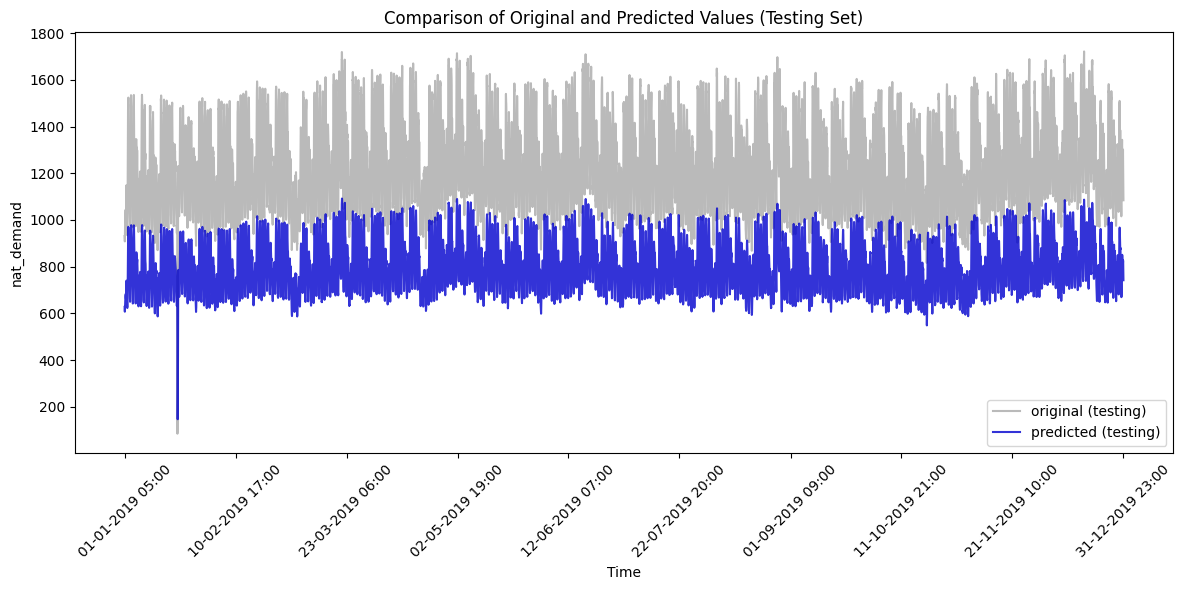

Training Metrics (ANN):
RMSE: 416.8301
MAE: 407.2572
MSE: 173747.3716

Testing Metrics (ANN):
RMSE: 444.6018
MAE: 435.9327
MSE: 197670.8035


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Select the features for training
selected_features = ['MA_3', 'Lag_1', 'T2M_toc']

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df2_copy))

# Split the dataset into training and testing using iloc
X_train = df2_copy[selected_features].iloc[:threshold_index]
y_train = df2_copy['nat_demand'].iloc[:threshold_index]
X_test = df2_copy[selected_features].iloc[threshold_index:]
y_test = df2_copy['nat_demand'].iloc[threshold_index:]

# Define and compile the ANN model with dropout layers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))  # Input shape adjusted for 3 features
model.add(Dropout(0.2))  # Add a dropout layer with a 20% dropout rate
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data for the testing set
ax.plot(df2_copy['datetime'].iloc[threshold_index:], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df2_copy['datetime'].iloc[threshold_index:], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics (ANN):")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print()
print("Testing Metrics (ANN):")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")

### ANN on 3 features without dropout

Epoch 1/20
1095/1095 [==============================] - 3s 2ms/step - loss: 33226.2539 - val_loss: 3615.2551
Epoch 2/20
1095/1095 [==============================] - 3s 2ms/step - loss: 3568.5110 - val_loss: 3535.8147
Epoch 3/20
1095/1095 [==============================] - 3s 2ms/step - loss: 3508.4158 - val_loss: 3393.7988
Epoch 4/20
1095/1095 [==============================] - 4s 3ms/step - loss: 3404.8420 - val_loss: 3461.1670
Epoch 5/20
1095/1095 [==============================] - 3s 2ms/step - loss: 3318.4729 - val_loss: 3184.5586
Epoch 6/20
1095/1095 [==============================] - 2s 2ms/step - loss: 3275.8860 - val_loss: 3164.5869
Epoch 7/20
1095/1095 [==============================] - 3s 2ms/step - loss: 3263.0508 - val_loss: 3430.6099
Epoch 8/20
1095/1095 [==============================] - 3s 2ms/step - loss: 3243.2375 - val_loss: 3059.5232
Epoch 9/20
1095/1095 [==============================] - 3s 3ms/step - loss: 3225.6384 - val_loss: 3302.3923
Epoch 10/20
1095/1095 [====

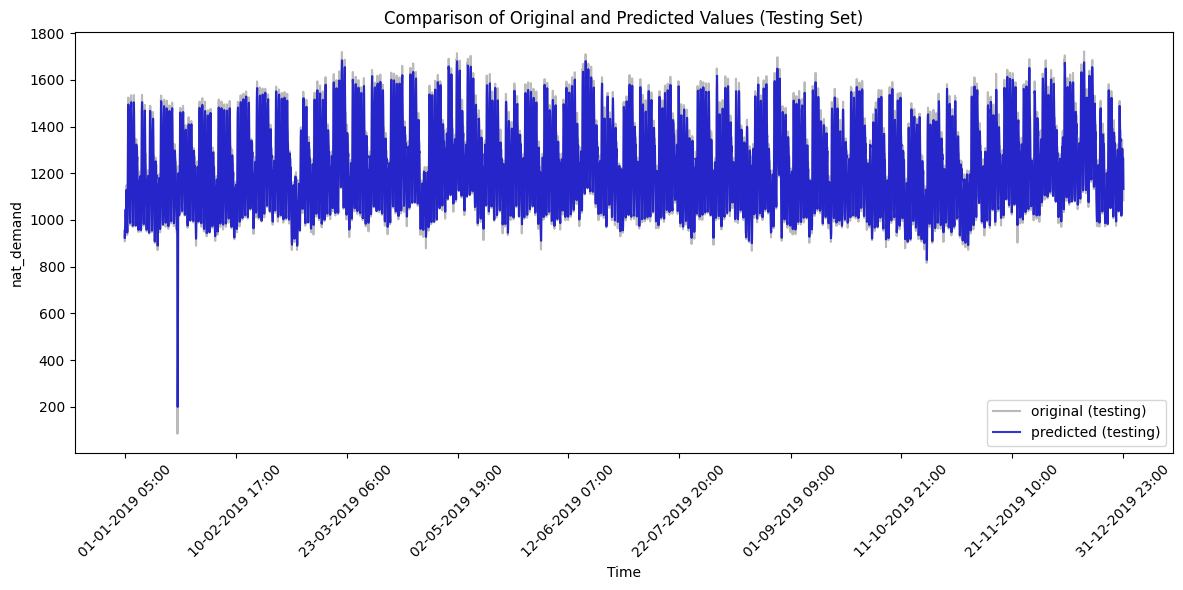

Training Metrics (ANN):
RMSE: 55.4907
MAE: 42.3411
MSE: 3079.2134

Testing Metrics (ANN):
RMSE: 55.3698
MAE: 42.2983
MSE: 3065.8147


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Select the features for training
selected_features = ['MA_3', 'Lag_1', 'T2M_toc']

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df2_copy))

# Split the dataset into training and testing using iloc
X_train = df2_copy[selected_features].iloc[:threshold_index]
y_train = df2_copy['nat_demand'].iloc[:threshold_index]
X_test = df2_copy[selected_features].iloc[threshold_index:]
y_test = df2_copy['nat_demand'].iloc[threshold_index:]

# Define and compile the ANN model with dropout layers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))  # Input shape adjusted for 3 features
#model.add(Dropout(0.2))  # Add a dropout layer with a 20% dropout rate
model.add(Dense(8, activation='relu'))
#model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(4, activation='relu'))
#model.add(Dropout(0.2))  # Add another dropout layer with a 20% dropout rate
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data for the testing set
ax.plot(df2_copy['datetime'].iloc[threshold_index:], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df2_copy['datetime'].iloc[threshold_index:], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df2_copy) - 1, num_ticks, dtype=int)
x_ticks = df2_copy['datetime'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics (ANN):")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print()
print("Testing Metrics (ANN):")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")

### Results & Conclusion

Linear Regression - >

Training Metrics:
RMSE: 50.0548
MAE: 38.6008
MSE: 2505.4867

Testing Metrics:
RMSE: 49.3725
MAE: 37.6676
MSE: 2437.6449

Polynomial Regression - >

Training Metrics (Polynomial Regression):
RMSE: 44.4972
MAE: 34.4208
MSE: 1980.0046

Testing Metrics (Polynomial Regression):
RMSE: 46.5013
MAE: 35.4454
MSE: 2162.3681

Polynomial Regression with 3 features - >


Training Metrics (Polynomial Regression):
RMSE: 52.2322
MAE: 40.2678
MSE: 2728.2050

Testing Metrics (Polynomial Regression):
RMSE: 53.0913
MAE: 40.3859
MSE: 2818.6825

ANN on all features with dropout - >

Training Metrics (ANN):
RMSE: 447.2276
MAE: 437.8387
MSE: 200012.5482

Testing Metrics (ANN):
RMSE: 477.1419
MAE: 468.6305
MSE: 227664.3898

ANN Model on 3  features with dropout - >

Training Metrics (ANN):
RMSE: 416.8301
MAE: 407.2572
MSE: 173747.3716

Testing Metrics (ANN):
RMSE: 444.6018
MAE: 435.9327
MSE: 197670.8035

ANN on 3 features without dropout - >

Training Metrics (ANN):
RMSE: 55.4907
MAE: 42.3411
MSE: 3079.2134

Testing Metrics (ANN):
RMSE: 55.3698
MAE: 42.2983
MSE: 3065.8147

Among the models, Polynomial Regression with 3 features demonstrates the best balance between training and testing performance, showcasing lower RMSE and MAE values compared to other methods. ANN models, especially with dropout, appear to be overfitting, resulting in higher RMSE and MAE on the test set.








